In [49]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchsummary import summary

# Load dataset and create dataloaders

In [50]:
dataset_test_path = "../../part1_bballs_test.npz"
dataset_train_path = "../../part1_bballs_training.npz"
batch_size = 4

dataset_train = np.load(dataset_train_path,allow_pickle=True)
print(np.reshape(dataset_train['data'][2],(1,32,32)).shape)
print(dataset_train['label'])

dataset_test = np.load(dataset_test_path,allow_pickle=True)

class CustomImageDataset(Dataset):
    def __init__(self, file_dir , transform=None, target_transform=None):
        self.file_dir = file_dir
        dataset_file = np.load(file_dir,allow_pickle=True)
        self.data = dataset_file['data']
        self.labels = dataset_file['label'] -1
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = np.reshape(self.data[idx],(1,32,32))
        image = np.float32(image)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

training_data = CustomImageDataset(dataset_train_path)
test_data = CustomImageDataset(dataset_test_path)
train_dataloader = DataLoader(training_data, batch_size = batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle=True)

(1, 32, 32)
[1 1 1 3 2 2 2 1 2 1 2 1 3 2 3 3 3 3 1 2 3 3 1 2 2 2 3 2 1 1 1 1 3 1 3 1 2
 2 1 3 1 1 3 2 3 1 2 2 1 3 2 3 2 2 3 3 1 1 3 3 2 3 3 1 2 1 3 2 3 1 2 3 2 3
 3 1 1 2 1 2 3 3 2 1 2 3 1 1 2 2 1 3 1 1 2 2 1 1 3 2 3 1 1 2 2 1 3 1 3 3 2
 2 3 1 1 2 3 1 1 3 1 3 2 3 2 2 1 2 1 1 2 3 3 1 2 3 1 2 3 1 1 1 2 1 2 2 3 1
 2 1 1 1 1 1 1 3 1 1 1 3 3 1 1 3 3 1 3 3 3 2 1 3 1 3 1 3 3 1 3 3 1 3 2 2 1
 3 1 3 1 1 2 2 3 1 3 2 3 1 1 1 3 3 1 1 1 3 1 2 1 3 2 3 3 2 3 2 1 1 3 3 1 1
 2 3 2 3 1 1 2 3 3 2 3 2 2 1 2 2 2 3 3 1 1 3 3 1 2 3 3 2 1 1 3 1 1 2 2 3 1
 2 1 2 1 2 3 2 1 3 3 1 1 2 2 2 1 2 3 1 1 2 3 3 3 2 1 3 2 1 3 2 2 2 2 1 1 1
 3 3 2 2 1 3 2 3 1 1 1 2 3 1 1 1 3 3 1 1 1 1 1 3 1 3 3 2 1 1 2 3 1 2 3 2 1
 1 2 3 1 3 3 2 2 2 3 1 1 3 3 2 3 1 3 3 1 3 3 1 2 2 2 2 3 3 1 2 1 3 3 1 1 2
 3 2 2 1 2 2 1 2 1 2 3 2 3 3 3 3 3 2 1 2 2 1 1 3 1 1 3 1 1 2 2 2 3 3 1 3 2
 2 3 3 2 1 3 3 2 2 1 1 1 3 1 1 3 2 3 1 1 3 1 1 2 3 2 2 1 2 2 2 2 2 3 2 3 3
 1 2 1 1 3 2 1 2 1 1 3 1 1 2 2 1 3 1 3 2 1 2 3 1 2 3 3 2 3 2 1 2 1 2 3 2 3
 1 1 1 1 1 2 

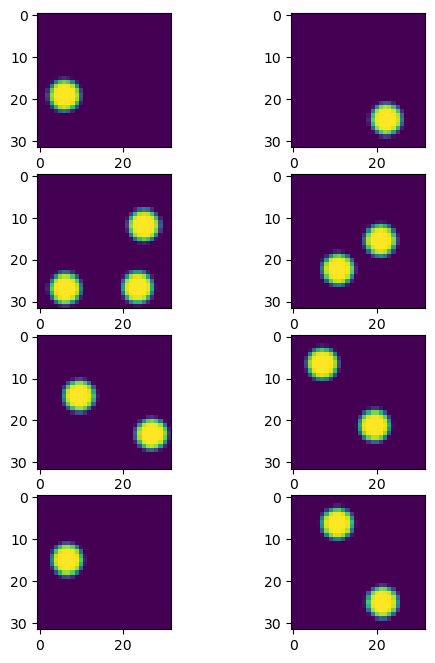

In [51]:
# create figure
fig = plt.figure(figsize=(6, 8))

# setting values to rows and column variables
rows = 4
columns = 2

for i in range(1,9):
    B_example_image = np.reshape(np.array(dataset_train['data'][i][0]),(32,32))
    fig.add_subplot(rows, columns, i)
    plt.imshow(B_example_image)

plt.show()

In [52]:
# test device if it works
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(f"Using {device} device")

# parms
classes_num = 3

# create model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size = 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(1024, 64),
            nn.Linear(64, classes_num)
        )

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.conv_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

Using cuda device


In [53]:
# show model detail
summary(model, input_size=(1, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             160
              ReLU-2           [-1, 16, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           4,640
              ReLU-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 32, 16, 16]           9,248
              ReLU-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 16, 16, 16]           4,624
              ReLU-9           [-1, 16, 16, 16]               0
        MaxPool2d-10             [-1, 16, 8, 8]               0
          Flatten-11                 [-1, 1024]               0
           Linear-12                   [-1, 64]          65,600
           Linear-13                    [-1, 3]             195
Total params: 84,467
Trainable params: 

In [54]:
# define training and testing functions

# define loss func and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.071364  [    4/  500]
loss: 0.485324  [  404/  500]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.327411 

Epoch 2
-------------------------------
loss: 0.896491  [    4/  500]
loss: 0.012431  [  404/  500]
Test Error: 
 Accuracy: 92.5%, Avg loss: 0.164679 

Epoch 3
-------------------------------
loss: 0.000908  [    4/  500]
loss: 0.001877  [  404/  500]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.438433 

Epoch 4
-------------------------------
loss: 0.000864  [    4/  500]
loss: 0.000246  [  404/  500]
Test Error: 
 Accuracy: 83.0%, Avg loss: 0.385710 

Epoch 5
-------------------------------
loss: 0.000345  [    4/  500]
loss: 0.004361  [  404/  500]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.334941 

Done!
